In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Carregando dataset
dataset = np.loadtxt("dataset/aerogerador.dat")
dataset

array([[  0. ,   0. ],
       [  0. ,   0. ],
       [  0. ,   0. ],
       ...,
       [ 14.1, 508. ],
       [ 14.3, 508. ],
       [ 14.4, 503. ]])

In [59]:
vel = dataset[:, 0]  # Velocidades
Pot = dataset[:, 1]  # Potências

vel.shape, Pot.shape

((2250,), (2250,))

In [60]:
def create_starting_population(individuals, chromosome_length):
    population = np.zeros((individuals, chromosome_length))
    for i in range(individuals):
        population[i, :] = np.random.rand(chromosome_length) * np.sqrt(2 / (chromosome_length))

    return population

def calculate_fitness(X, y, population):
    fitness_scores = []
    fitness_coefficients = []
    
    for i in population:
        coefficients = np.array(i)

        y_pred = np.dot(X, coefficients)
        sea_error = np.sum(np.abs(y - y_pred)) # Sum of Absolut Errors
        
        fitness_scores.append(sea_error)
        fitness_coefficients.append(coefficients)

    return fitness_scores, fitness_coefficients

def select_individual_by_tournament(population, scores):
    population_size = len(scores)
    fighter_1 = random.randint(0, population_size - 1)
    fighter_2 = random.randint(0, population_size - 1)
    fighter_1_fitness = scores[fighter_1]
    fighter_2_fitness = scores[fighter_2]
    
    if fighter_1_fitness <= fighter_2_fitness:
        winner = fighter_1
    else: winner = fighter_2

    return population[winner, :]

def breed_by_crossover(chromosome_length, parent_1, parent_2):
    crossover_point = random.randint(1, chromosome_length - 1)

    child_1 = np.hstack((parent_1[0:crossover_point], parent_2[crossover_point:]))
    child_2 = np.hstack((parent_2[0:crossover_point], parent_1[crossover_point:]))

    return child_1, child_2

def randomly_mutate_population(population, mutation_probability):
    random_mutation_array = np.random.random(size=population.shape)
    random_mutation_boolean = random_mutation_array <= mutation_probability
    population[random_mutation_boolean] += np.random.randn() * 0.1

    return population

In [61]:
from sklearn.metrics import r2_score

def criteria_metrics(type, y_true, y_pred, X, num_coeff):
    if type == "R2":
        return r2_score(y_true, y_pred)
    elif type == "Adj_R2":
        return 1 - (1 - r2_score(y_true, y_pred)) * ((len(y_true) - 1) / (len(y_true) - X.shape[1] - 1))
    elif type == "AIC":
        res = y_true - y_pred
        sum_res = np.sum(res**2)
        return len(y_true) * np.log(sum_res) + 2 * num_coeff

def polynomial_matrix(k, X):
    if k == 1:
        return np.column_stack((np.ones(X.shape[0]), X)) 
    else:
        polynomials = [X ** pol for pol in range(0, k + 1)]
        return np.column_stack(polynomials)
        
def train_multi_linear_regressor_ga(X_train, y_train, degrees_list, num_exec, population_size, maximum_generation, mutation_rate):
    
    degrees_best_models = [] 
    
    for degree in degrees_list:
        X = polynomial_matrix(degree, X_train)
        y = y_train

        coeffs_list = []
        r2s_list = []
        adj_r2s_list = []
        aics_list = []
        
        for exec in range(num_exec):
            print("Execution {} - Degree {}".format(exec, degree))
            
            chromosome_length = degree + 1
            
            population = create_starting_population(population_size, chromosome_length)
            
            scores, coefficients = calculate_fitness(X, y, population)
            best_individual = np.argmin(scores)
            best_score = scores[best_individual]
            best_coefficients = coefficients[best_individual]
            
            print("Starting best error - SEA: {}".format(best_score))
            
            for generation in range(maximum_generation):
                new_population = []
            
                for i in range(int(population_size / 2)):
                    parent_1 = select_individual_by_tournament(population, scores)
                    parent_2 = select_individual_by_tournament(population, scores)
                    child_1, child_2 = breed_by_crossover(chromosome_length, parent_1, parent_2)
                    new_population.append(child_1)
                    new_population.append(child_2)
            
                new_population = np.array(new_population)
                new_population = randomly_mutate_population(new_population, mutation_rate)
            
                new_scores, new_coefficients = calculate_fitness(X, y, new_population)
                new_best_individual = np.argmin(new_scores)

                if new_scores[new_best_individual] < best_score:
                    best_score = new_scores[new_best_individual]
                    best_coefficients = new_coefficients[new_best_individual]
                    
                if generation % 100 == 0 and generation != 0:
                    print("\t Generation {} - SEA {}".format(generation, best_score))
            
            print("\t Final generations - Global Best SEA {}".format(best_score))
            
            y_pred = X @ best_coefficients

            r2 = criteria_metrics("R2", y_train, y_pred, X, best_coefficients.shape[0])
            adj_r2 = criteria_metrics("Adj_R2", y_train, y_pred, X, best_coefficients.shape[0])
            aic = criteria_metrics("AIC", y_train, y_pred, X, best_coefficients.shape[0])
            
            coeffs_list.append(best_coefficients)
            r2s_list.append(r2)
            adj_r2s_list.append(adj_r2)
            aics_list.append(aic)

        zipped_model = list(zip(r2s_list, coeffs_list, adj_r2s_list, aics_list))
        zipped_model.sort(reverse=True)
        best_models = zipped_model[:3] # Salvando as 3 melhores execuções com base no R2 para o grau atual de polinomio
        degrees_best_models.append(best_models)
        
        
    return degrees_best_models


In [62]:
degrees_list = [i for i in range(5, 6)]
best_models = train_multi_linear_regressor_ga(X_train=vel, y_train=Pot, degrees_list=degrees_list, num_exec=3, \
                                             population_size=10, maximum_generation=20000, mutation_rate=0.95)

Execution 0 - Degree 5
Starting best error - SEA: 15242340.93718613
	 Generation 100 - SEA 345137.69409813866
	 Generation 200 - SEA 89725.25776043364
	 Generation 300 - SEA 46495.07509822068
	 Generation 400 - SEA 46495.07509822068
	 Generation 500 - SEA 46495.07509822068
	 Generation 600 - SEA 46495.07509822068
	 Generation 700 - SEA 46495.07509822068
	 Generation 800 - SEA 46495.07509822068
	 Generation 900 - SEA 46495.07509822068
	 Generation 1000 - SEA 46495.07509822068
	 Generation 1100 - SEA 45363.56811828652
	 Generation 1200 - SEA 45363.56811828652
	 Generation 1300 - SEA 45363.56811828652
	 Generation 1400 - SEA 45363.56811828652
	 Generation 1500 - SEA 45363.56811828652
	 Generation 1600 - SEA 45363.56811828652
	 Generation 1700 - SEA 45363.56811828652
	 Generation 1800 - SEA 45363.56811828652
	 Generation 1900 - SEA 45363.56811828652
	 Generation 2000 - SEA 45363.56811828652
	 Generation 2100 - SEA 45363.56811828652
	 Generation 2200 - SEA 45363.56811828652
	 Generation 230

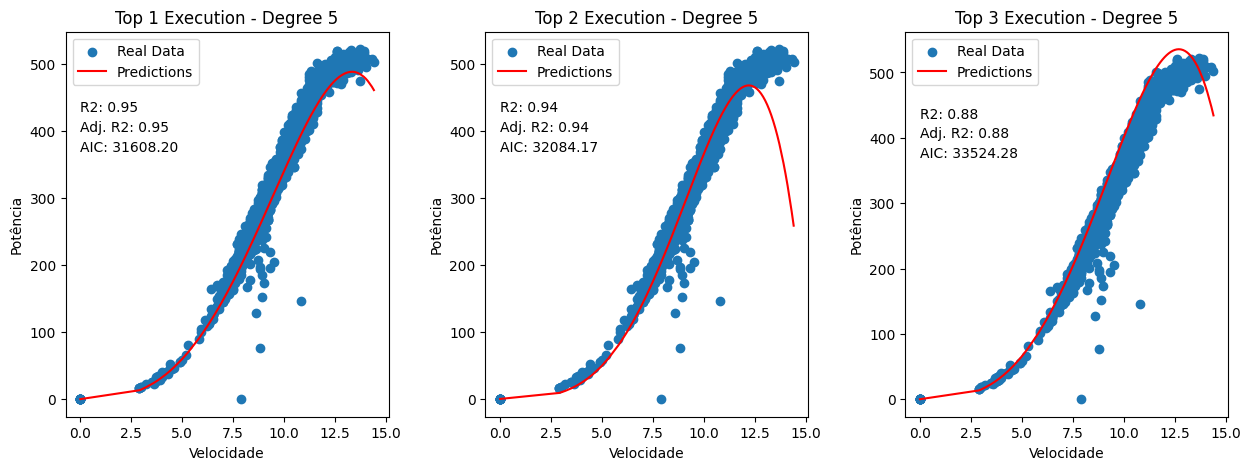

In [63]:
for i, models in enumerate(best_models):
    degree = degrees_list[i]
    degree -= 1
    r2s_list, coeffs_list, adj_r2s_list, aics_list = zip(*models)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    X = polynomial_matrix(degree + 1, vel)
    y = Pot.reshape(-1, 1)

    for i in range(3):
        coefficients = coeffs_list[i]
        y_pred = X @ coefficients
        
        sorted_order = np.argsort(X[:, 1])
        X_sorted = X[sorted_order]
        y_pred_sorted = y_pred[sorted_order]
        
        axes[i].scatter(X[:, 1], y, label='Real Data')
        axes[i].plot(X_sorted[:, 1], y_pred_sorted, color='red', label='Predictions')
        axes[i].set_title("Top {} Execution - Degree {}".format(i+1, degree+1))
        axes[i].set_xlabel('Velocidade')
        axes[i].set_ylabel('Potência')
        # axes[i].set_xlim(-1, 15)
        # axes[i].set_ylim(-100, 600)
        axes[i].text(0, 430, 'R2: {:.2f}'.format(r2s_list[i]))
        axes[i].text(0, 400, 'Adj. R2: {:.2f}'.format(adj_r2s_list[i]))
        axes[i].text(0, 370, 'AIC: {:.2f}'.format(aics_list[i]))
        axes[i].legend()

    plt.subplots_adjust(wspace=0.3)
    plt.show()